---

## Load Library and Set Option

### Library

In [89]:
# 데이터 분석 기본 라이브러리 관련
import os
import sys
import warnings
import numpy as np
import pandas as pd

# EDA 관련
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno

# 데이터 전처리 관련
import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# 머신러닝 모델 관련
from sklearn.ensemble import RandomForestClassifier  # RandomForest
from xgboost import XGBClassifier  # XGBoost
#from lightgbm import LGBMClassifier  # LightGBM

# 평가 지표 관련
from sklearn.metrics import confusion_matrix  # 오차행렬
from sklearn.metrics import accuracy_score  # 정확도
from sklearn.metrics import precision_score  # 정밀도
from sklearn.metrics import recall_score  # 재현율
from sklearn.metrics import roc_auc_score  # auc score
from sklearn.metrics import f1_score

### Options

In [90]:
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

---

## Exploratory Data Analysis, EDA

### Load data

#### AFSNT.CSV 불러오기

In [91]:
# 2017.01.01 ~ 2019.06.30 운항실적 데이터
# 이게 사실상 학습데이터(train data)
data_AFSNT = pd.read_csv('data/AFSNT.CSV',
                         encoding='cp949',
                         header=0)
data_AFSNT.columns = ['연', '월', '일', '요일', '공항', '상대공항',
                      '항공사', '편명', '등록기호', '출도착', '부정기편',
                      '계획시각', '실제시각', '지연여부', '지연사유', '결항여부', '결항사유']
data_AFSNT.head()

,연,월,일,요일,공항,상대공항,항공사,편명,등록기호,출도착,부정기편,계획시각,실제시각,지연여부,지연사유,결항여부,결항사유
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,일,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


#### AFSNT_DLY.CSV 불러오기

In [92]:
# 2019.09.16 ~ 2019.09.30 지연율 계산
# 이게 사실상 시험데이터(test data)
# 실제로 이걸 나중에 예측해야함
data_AFSNT_DLY = pd.read_csv('data/AFSNT_DLY.CSV',
                             encoding='cp949',
                             header=0,
                             names=['연', '월', '일', '요일', '공항', '상대공항',
                                    '항공사', '편명', '출도착', '계획시각', '지연여부', '지연확률'])
data_AFSNT_DLY.head()

,연,월,일,요일,공항,상대공항,항공사,편명,출도착,계획시각,지연여부,지연확률
0,2019,9,16,월,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,월,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,월,ARP1,ARP3,L,L1720,A,14:40,NaN,NaN
3,2019,9,16,월,ARP3,ARP1,L,L1720,D,13:30,NaN,NaN
4,2019,9,16,월,ARP4,ARP3,L,L1808,A,20:10,NaN,NaN


#### SFSNT.CSV 불러오기

In [93]:
# 2019년 하계 스케쥴 중 7월 ~ 9월이 포함된 시즌데이터
data_SFSNT = pd.read_csv('data/SFSNT.CSV',
                         encoding='cp949',
                         header=0,
                         names=['시즌코드', '편명', '공항', '상대공항', '출발시각', '도착시각', '항공사',
                                '월', '화', '수', '목', '금', '토', '일', '시작일자', '종료일자', '부정기편'])
data_SFSNT.head()

,시즌코드,편명,공항,상대공항,출발시각,도착시각,항공사,월,화,수,목,금,토,일,시작일자,종료일자,부정기편
0,S19,A1915,ARP1,ARP3,7:55,9:05,A,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
1,S19,A1904,ARP3,ARP1,7:55,9:05,A,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
2,S19,I1304,ARP3,ARP1,8:00,9:15,I,Y,NaN,Y,Y,Y,NaN,Y,20190331,20191026,N
3,S19,B1802,ARP2,ARP1,8:00,8:55,B,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
4,S19,J1106,ARP1,ARP2,8:00,9:05,J,NaN,Y,Y,NaN,Y,Y,NaN,20190730,20190824,N


### Data Dictionary

In [94]:
ARP_name = {
    'ARP1': '김포', 'ARP2': '김해', 'ARP3': '제주',
    'ARP4': '광주', 'ARP5': '인천', 'ARP6': '청주',
    'ARP7': '무안', 'ARP8': '대구', 'ARP9': '여수',
    'ARP10': '양양', 'ARP11': '포항', 'ARP12': '사천',
    'ARP13': '군산', 'ARP14': '원주', 'ARP15': '울산'
}

In [95]:
FLO_name = {
    'A': '아시아나', 'B': '에어부산', 'C': '기타',
    'D': '기타', 'E': '기타', 'F': '이스타항공',
    'G': '기타', 'H': '제주항공', 'I': '진에어',
    'J': '대한항공', 'K': '기타', 'L': '티웨이항공',
    'M': '기타'
}

In [96]:
delay_code = {  # WEATHER : 기상관련 지연
    'A01': '안개', 'A02': '강설', 'A03': '강우',
    'A04': '태풍', 'A05': '강풍', 'A06': '상층풍',
    'A07': '운고', 'A08': '기상-황사', 'A09': '기상-항로',
    'A10': '기상-뇌우', 'A99': '기상-기타',

    # AIRPORT AND GOVERNMENTAL AUTHORITIES : 공항 및 정부기관 인허가 관련 지연
    'B01': '계류장혼잡', 'B02': '사고', 'B03': '활주로사정',
    'B04': '행사', 'B05': '항행시설고장', 'B06': '공항폐쇄',
    'B07': '이륙대기', 'B08': 'Curfew',

    # TECHNICAL AND AIRCRAFT EQUIPMENT : 기술, 항공기 장비로 인한 지연
    # FLIGHT OPERATIONS AND CREWING : 항공기 운항 및 승무원으로 인한 지연
    'C01': 'A/C 정비', 'C02': 'A/C 접속', 'C03': '승객접속',
    'C04': '여객처리', 'C05': '지상조업', 'C06': 'SKD변경',
    'C07': '항공기부족', 'C08': '연료재급유', 'C09': '환자',
    'C10': '제방빙작업', 'C11': '보안검색', 'C12': '조종사자격',
    'C13': '승무원휴식', 'C14': '승무원연결', 'C15': '화물탑재',
    'C16': '화물연결', 'C17': '화물수요부족',

    # 그외
    'D01': '항로혼잡', 'D02': '영공통과불허',
    'Z01': '복합원인', 'Z99': '기타'
}

### Check the size of data

In [97]:
# AFSNT.CSV 관련
data_AFSNT.shape

(987709, 17)

In [98]:
# AFSNT_DLY.CSV 관련
data_AFSNT_DLY.shape

(16076, 12)

In [99]:
# SFSNT.CSV 관련
data_SFSNT.shape

(1186, 17)

### Check missing values

#### AFSNT

In [100]:
data_AFSNT.isnull().sum()

연            0
월            0
일            0
요일           0
공항           0
상대공항         0
항공사          0
편명           0
등록기호      8263
출도착          0
부정기편         0
계획시각         0
실제시각         0
지연여부         0
지연사유    868772
결항여부         0
결항사유    979450
dtype: int64

In [101]:
# 결측치가 있는 행 비율 보기
# 결측치가 있는 데이터는 각각 1%도 안된다는 것을 알 수 있다
# 이 중에서 지연사유나 결항사유는 지연 혹은 결항이 되지 않을 시 공백으로 남는게 타당하므로 고려하지 않아도 될듯
missing_df = data_AFSNT.isnull().sum().reset_index()
missing_df.columns = ['column', 'count']
missing_df['ratio'] = missing_df['count'] / len(data_AFSNT) * 100
missing_df.loc[missing_df['ratio'] != 0]

,column,count,ratio
8,등록기호,8263,0.836582
14,지연사유,868772,87.958295
16,결항사유,979450,99.163823


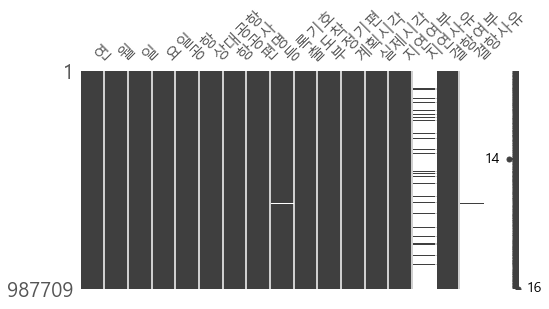

In [102]:
# 결측 데이터 시각화
msno.matrix(data_AFSNT, figsize=(8,4));

#### AFSNT_DLY

In [103]:
data_AFSNT_DLY.isnull().sum() # TEST 데이터는 깔끔하게 되어있는듯 싶다

연           0
월           0
일           0
요일          0
공항          0
상대공항        0
항공사         0
편명          0
출도착         0
계획시각        0
지연여부    16076
지연확률    16076
dtype: int64

In [104]:
missing_df_dly = data_AFSNT_DLY.isnull().sum().reset_index()
missing_df_dly.columns = ['column', 'count']
missing_df_dly['ratio'] = missing_df_dly['count'] / len(data_AFSNT_DLY) * 100
missing_df_dly.loc[missing_df_dly['ratio'] != 0]

,column,count,ratio
10,지연여부,16076,100.0
11,지연확률,16076,100.0


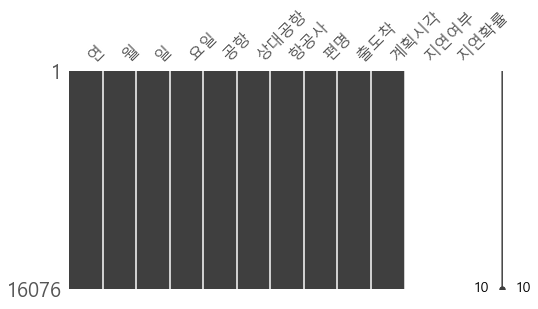

In [105]:
# 결측 데이터 시각화
msno.matrix(data_AFSNT_DLY, figsize=(8,4));

#### SFSNT

In [106]:
data_SFSNT.isnull().sum()

시즌코드      0
편명        0
공항        0
상대공항      0
출발시각     18
도착시각     19
항공사       0
월       432
화       436
수       441
목       441
금       438
토       437
일       459
시작일자      0
종료일자      0
부정기편      0
dtype: int64

In [107]:
missing_df_sfsnt = data_SFSNT.isnull().sum().reset_index()
missing_df_sfsnt.columns = ['column', 'count']
missing_df_sfsnt['ratio'] = missing_df_sfsnt['count'] / len(data_SFSNT) * 100
missing_df_sfsnt.loc[missing_df_sfsnt['ratio'] != 0]

,column,count,ratio
4,출발시각,18,1.517707
5,도착시각,19,1.602024
7,월,432,36.424958
8,화,436,36.762226
9,수,441,37.183811
10,목,441,37.183811
11,금,438,36.930860
12,토,437,36.846543
13,일,459,38.701518


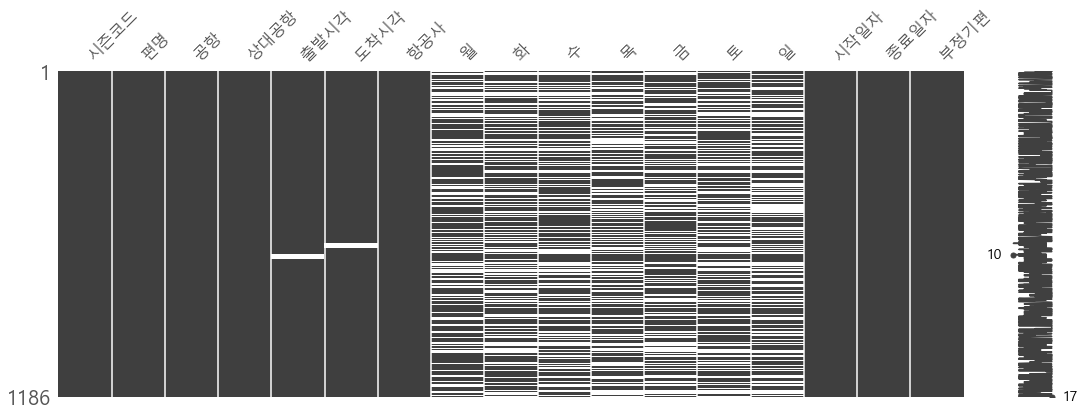

In [108]:
# 결측 데이터 시각화
msno.matrix(data_SFSNT, figsize=(18,6));

### 데이터 특징의 타입 확인하기
사실 대부분의 데이터가 연속형 데이터 타입이 아닌 `범주형 데이터 타입`임을 확인할 수 있다.

#### AFSNT

In [109]:
data_AFSNT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987709 entries, 0 to 987708
Data columns (total 17 columns):
연       987709 non-null int64
월       987709 non-null int64
일       987709 non-null int64
요일      987709 non-null object
공항      987709 non-null object
상대공항    987709 non-null object
항공사     987709 non-null object
편명      987709 non-null object
등록기호    979446 non-null object
출도착     987709 non-null object
부정기편    987709 non-null object
계획시각    987709 non-null object
실제시각    987709 non-null object
지연여부    987709 non-null object
지연사유    118937 non-null object
결항여부    987709 non-null object
결항사유    8259 non-null object
dtypes: int64(3), object(14)
memory usage: 128.1+ MB


#### AFSNT_DLY

In [110]:
data_AFSNT_DLY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16076 entries, 0 to 16075
Data columns (total 12 columns):
연       16076 non-null int64
월       16076 non-null int64
일       16076 non-null int64
요일      16076 non-null object
공항      16076 non-null object
상대공항    16076 non-null object
항공사     16076 non-null object
편명      16076 non-null object
출도착     16076 non-null object
계획시각    16076 non-null object
지연여부    0 non-null float64
지연확률    0 non-null float64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.5+ MB


#### SFSNT

In [111]:
data_SFSNT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 17 columns):
시즌코드    1186 non-null object
편명      1186 non-null object
공항      1186 non-null object
상대공항    1186 non-null object
출발시각    1168 non-null object
도착시각    1167 non-null object
항공사     1186 non-null object
월       754 non-null object
화       750 non-null object
수       745 non-null object
목       745 non-null object
금       748 non-null object
토       749 non-null object
일       727 non-null object
시작일자    1186 non-null int64
종료일자    1186 non-null int64
부정기편    1186 non-null object
dtypes: int64(2), object(15)
memory usage: 157.6+ KB


### Check features
기본적으로 종속변수의 분포를 살펴봅니다. 종속변수란 다른 변수들의 관계를 주로 추론하고, 최종적으로는 예측하고자 하는 변수입니다.

In [112]:
# 비행기 지연여부 수
data_AFSNT['지연여부'].value_counts()

N    868772
Y    118937
Name: 지연여부, dtype: int64

In [113]:
# 전체 지연여부 데이터 중 지연 데이터 수
# 전체 데이터 중에서 약 12.041705% 정도 지연되는 것을 볼 수 있음
# 예측해야할 타켓이 현재 imblanced된 상태임을 알 수 있음
data_AFSNT['지연여부'].value_counts() / len(data_AFSNT) * 100

N    87.958295
Y    12.041705
Name: 지연여부, dtype: float64

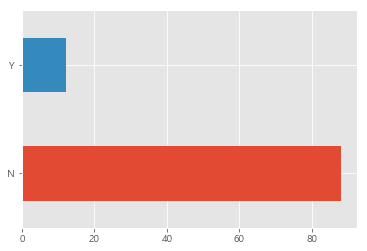

In [114]:
(data_AFSNT['지연여부'].value_counts() / len(data_AFSNT) * 100).plot(kind='barh')
plt.show()

#### 범주형 변수 확인하기

In [115]:
# 지연여부에 따른 변수 비율 확인
def show_cat_var(dataset,feature,legend_flag=True):
    (dataset[feature].value_counts() / len(dataset[feature]) * 100).sort_index().plot(kind='bar')
    plt.title('{}의 전체 비율'.format(feature))
    plt.xlabel('{}'.format(feature))
    plt.ylabel('비율(%)')
    plt.show()
    if dataset is data_AFSNT:
        delay = dataset[dataset['지연여부']=='Y'][feature].value_counts() / len(dataset[dataset['지연여부']=='Y'][feature]) * 100
        not_delay = dataset[dataset['지연여부']=='N'][feature].value_counts() / len(dataset[dataset['지연여부']=='N'][feature]) * 100
        df = pd.DataFrame([delay,not_delay])
        df.index = ['지연 O','지연 X']
        df.plot(kind='bar',stacked=True, figsize=(10,5),legend=legend_flag)
        plt.title('{}의 지연여부별 비율'.format(feature))
        plt.ylabel('비율(%)')
        plt.show()

#### 월

In [116]:
# 데이터의 시작과 끝을 고려해보면 마지막이 6월까지이기 때문에 7월부터는 데이터가 부족함
# show_cat_var(data_AFSNT,'월')

#### 일

In [117]:
#show_cat_var(data_AFSNT,'일',False)

#### 요일

In [118]:
#show_cat_var(data_AFSNT,'요일')

#### 공항

In [119]:
data_AFSNT['공항'] = data_AFSNT['공항'].map(lambda x: ARP_name[x])
data_AFSNT_DLY['공항'] = data_AFSNT_DLY['공항'].map(lambda x: ARP_name[x])

In [120]:
#show_cat_var(data_AFSNT,'공항')

#### 상대공항

In [121]:
data_AFSNT['상대공항'] = data_AFSNT['상대공항'].map(lambda x: ARP_name[x])
data_AFSNT_DLY['상대공항'] = data_AFSNT_DLY['상대공항'].map(lambda x: ARP_name[x])

In [122]:
#show_cat_var(data_AFSNT,'상대공항')

#### 항공사

In [123]:
data_AFSNT['항공사'] = data_AFSNT['항공사'].map(lambda x: FLO_name[x])
data_AFSNT_DLY['항공사'] = data_AFSNT_DLY['항공사'].map(lambda x: FLO_name[x])

In [124]:
#show_cat_var(data_AFSNT,'항공사')

#### 등록기호

In [125]:
#show_cat_var(data_AFSNT,'등록기호',False)

#### 출 / 도착

In [126]:
#show_cat_var(data_AFSNT,'출도착')

#### 부정기편

In [127]:
#show_cat_var(data_AFSNT,'부정기편')

#### 지연사유

In [128]:
#show_cat_var(data_AFSNT,'지연사유',False)

#### 결항여부

In [129]:
#show_cat_var(data_AFSNT, '결항여부')

---

## Feature Engineering

### Treatment of missing values

In [130]:
data_AFSNT['지연사유'].fillna('X', axis=0, inplace =True)
data_AFSNT['결항사유'].fillna('X', axis=0, inplace =True)
data_AFSNT['등록기호'].fillna('NAN', axis=0, inplace =True)

In [131]:
data_AFSNT.isnull().sum() # 더이상의 결측치는 존재하지 않는다

연       0
월       0
일       0
요일      0
공항      0
상대공항    0
항공사     0
편명      0
등록기호    0
출도착     0
부정기편    0
계획시각    0
실제시각    0
지연여부    0
지연사유    0
결항여부    0
결항사유    0
dtype: int64

### Treatment of categorical variables
- Transform to numbers via LabelEncoder

In [132]:
# 등록기호
le_reg = LabelEncoder()
le_reg.fit(data_AFSNT['등록기호'])
data_AFSNT['등록기호'] = le_reg.transform(data_AFSNT['등록기호'])

# 편명
le_flight = LabelEncoder()
le_flight.fit(pd.unique(pd.concat([data_AFSNT['편명'],data_AFSNT_DLY['편명']])))
data_AFSNT['편명'] = le_flight.transform(data_AFSNT['편명'])
data_AFSNT_DLY['편명'] = le_flight.transform(data_AFSNT_DLY['편명'])
data_AFSNT_DLY['편명'] = data_AFSNT_DLY['편명'].apply(lambda x: str(x))

# 항공사
le_airline = LabelEncoder()
le_airline.fit(pd.unique(pd.concat([data_AFSNT['항공사'],data_AFSNT_DLY['항공사']])))
data_AFSNT['항공사'] = le_airline.transform(data_AFSNT['항공사'])
data_AFSNT_DLY['항공사'] = le_airline.transform(data_AFSNT_DLY['항공사'])
data_AFSNT_DLY['항공사'] = data_AFSNT_DLY['항공사'].apply(lambda x: str(x))

# 공항
le_airport = LabelEncoder()
le_airport.fit(pd.unique(pd.concat([data_AFSNT['공항'],data_AFSNT_DLY['공항']])))
data_AFSNT['공항'] = le_airport.transform(data_AFSNT['공항'])
data_AFSNT['상대공항'] = le_airport.transform(data_AFSNT['상대공항'])
data_AFSNT_DLY['공항'] = le_airport.transform(data_AFSNT_DLY['공항'])
data_AFSNT_DLY['상대공항'] = le_airport.transform(data_AFSNT_DLY['상대공항'])
data_AFSNT_DLY['공항'] = data_AFSNT_DLY['공항'].apply(lambda x: str(x))
data_AFSNT_DLY['상대공항'] = data_AFSNT_DLY['상대공항'].apply(lambda x: str(x))

# 출도착
le_da = LabelEncoder()
le_da.fit(data_AFSNT['출도착'])
data_AFSNT['출도착'] = le_da.transform(data_AFSNT['출도착'])
data_AFSNT_DLY['출도착'] = le_da.transform(data_AFSNT_DLY['출도착'])
data_AFSNT_DLY['출도착'] = data_AFSNT_DLY['출도착'].apply(lambda x: str(x))

# 부정기편
le_unsch = LabelEncoder()
le_unsch.fit(data_AFSNT['부정기편'])
data_AFSNT['부정기편'] = le_unsch.transform(data_AFSNT['부정기편'])

# 지연여부
le_delay = LabelEncoder()
le_delay.fit(data_AFSNT['지연여부'])
data_AFSNT['지연여부'] = le_delay.transform(data_AFSNT['지연여부'])

# 지연사유
le_delay_reason = LabelEncoder()
le_delay_reason.fit(data_AFSNT['지연사유'])
data_AFSNT['지연사유'] = le_delay_reason.transform(data_AFSNT['지연사유'])

# 결항여부
le_cancel = LabelEncoder()
le_cancel.fit(data_AFSNT['결항여부'])
data_AFSNT['결항여부'] = le_cancel.transform(data_AFSNT['결항여부'])

# 결항사유
le_cancel_reason = LabelEncoder()
le_cancel_reason.fit(data_AFSNT['결항사유'])
data_AFSNT['결항사유'] = le_cancel_reason.transform(data_AFSNT['결항사유'])

### Treatment of columns about time

In [133]:
# 날짜 형식 바꾸기

# AFSNT
data_AFSNT['연'] = data_AFSNT['연'].apply(lambda x: str(x)) 
data_AFSNT['월'] = data_AFSNT['월'].apply(lambda x: str(x))
data_AFSNT['일'] = data_AFSNT['일'].apply(lambda x: str(x))
data_AFSNT['날짜'] = data_AFSNT['연']+'-'+data_AFSNT['월']+'-'+data_AFSNT['일']
data_AFSNT['날짜'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_AFSNT.drop(['연','월','일','요일'],axis=1,inplace=True)
data_AFSNT = data_AFSNT[['날짜']+data_AFSNT.columns.tolist()[:-1]]

# AFSNT_DLY
data_AFSNT_DLY['연'] = data_AFSNT_DLY['연'].apply(lambda x: str(x))
data_AFSNT_DLY['월'] = data_AFSNT_DLY['월'].apply(lambda x: str(x))
data_AFSNT_DLY['일'] = data_AFSNT_DLY['일'].apply(lambda x: str(x))
data_AFSNT_DLY['날짜'] = data_AFSNT_DLY['연']+'-'+data_AFSNT_DLY['월']+'-'+data_AFSNT_DLY['일']
data_AFSNT_DLY['날짜'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_AFSNT_DLY.drop(['연','월','일','요일'],axis=1,inplace=True)
data_AFSNT_DLY = data_AFSNT_DLY[['날짜']+data_AFSNT_DLY.columns.tolist()[:-1]]

In [134]:
# 시간차 컬럼 추가
data_AFSNT['계획시각'] = data_AFSNT['계획시각'].apply(lambda x: str(x)).apply(lambda x: datetime.strptime(x, '%H:%M'))
data_AFSNT_DLY['계획시각'] = data_AFSNT_DLY['계획시각'].apply(lambda x: str(x)).apply(lambda x: datetime.strptime(x, '%H:%M'))
data_AFSNT['실제시각'] = data_AFSNT['실제시각'].apply(lambda x: str(x)).apply(lambda x: datetime.strptime(x, '%H:%M'))
data_AFSNT['시간차'] = data_AFSNT['실제시각']-data_AFSNT['계획시각']
data_AFSNT['시간차'] = data_AFSNT['시간차'].apply(lambda x: x.total_seconds()/60)

In [135]:
# 시간대 컬럼 추가
data_AFSNT['시간대']=data_AFSNT['계획시각'].apply(lambda X: X.hour)
data_AFSNT_DLY['시간대']=data_AFSNT_DLY['계획시각'].apply(lambda X: X.hour)
data_AFSNT_DLY['시간대'] = data_AFSNT_DLY['시간대'].apply(lambda x: str(x))

In [136]:
data_AFSNT.head()

,날짜,공항,상대공항,항공사,편명,등록기호,출도착,부정기편,계획시각,실제시각,지연여부,지연사유,결항여부,결항사유,시간차,시간대
0,2017-1-1,12,13,1,1408,90,1,0,1900-01-01 10:05:00,1900-01-01 10:32:00,0,34,0,21,27.0,10
1,2017-1-1,12,13,1,1407,90,0,0,1900-01-01 09:30:00,1900-01-01 09:31:00,0,34,0,21,1.0,9
2,2017-1-1,12,13,1,1409,90,0,0,1900-01-01 12:45:00,1900-01-01 13:03:00,0,34,0,21,18.0,12
3,2017-1-1,12,13,1,1410,90,1,0,1900-01-01 13:25:00,1900-01-01 14:09:00,1,18,0,21,44.0,13
4,2017-1-1,12,13,1,1411,90,0,0,1900-01-01 16:10:00,1900-01-01 16:31:00,0,34,0,21,21.0,16


### Delete canceled flights

In [137]:
data_AFSNT[data_AFSNT.결항여부==1].실제시각 

2736     1900-01-01
2737     1900-01-01
2887     1900-01-01
2888     1900-01-01
3579     1900-01-01
3580     1900-01-01
3581     1900-01-01
3582     1900-01-01
3788     1900-01-01
3789     1900-01-01
3878     1900-01-01
3879     1900-01-01
5682     1900-01-01
5683     1900-01-01
5684     1900-01-01
5685     1900-01-01
5686     1900-01-01
5689     1900-01-01
5729     1900-01-01
5730     1900-01-01
5772     1900-01-01
5781     1900-01-01
5782     1900-01-01
5783     1900-01-01
5784     1900-01-01
5785     1900-01-01
5786     1900-01-01
5787     1900-01-01
5793     1900-01-01
5797     1900-01-01
            ...    
979975   1900-01-01
979976   1900-01-01
979982   1900-01-01
979988   1900-01-01
979989   1900-01-01
979994   1900-01-01
979999   1900-01-01
980001   1900-01-01
980005   1900-01-01
980006   1900-01-01
980008   1900-01-01
980012   1900-01-01
980013   1900-01-01
980014   1900-01-01
980015   1900-01-01
980017   1900-01-01
980021   1900-01-01
980022   1900-01-01
980026   1900-01-01


In [138]:
cancel_flight_list = data_AFSNT[(data_AFSNT.결항여부 == 1)].index
print('결항 항공편 {}편 제외'.format(len(cancel_flight_list)))
data_AFSNT.drop(cancel_flight_list,inplace=True)

결항 항공편 8259편 제외


### make marks to link departure and arrival by flights

In [139]:
grouped_flight = data_AFSNT.copy()
grouped_flight.index = range(0, len(grouped_flight))
grouped_flight['항공사'] = grouped_flight['항공사'].apply(lambda x: str(x))
grouped_flight['편명'] = grouped_flight['편명'].apply(lambda x: str(x))
grouped_flight['등록기호'] = grouped_flight['등록기호'].apply(lambda x: str(x))
grouped_flight['날짜'] = grouped_flight['날짜'].apply(lambda x: str(x)[:10])
grouped_flight['기호'] = grouped_flight['항공사'] + '-' + grouped_flight['편명'] + \
    '-' + grouped_flight['등록기호'] + '-' + grouped_flight['날짜']
group_count = pd.DataFrame(grouped_flight['기호'].value_counts()).reset_index()
group_count.columns = ['기호', '기호값']
add_group_count = grouped_flight.merge(group_count, on='기호', how='inner')

changed_date_index = add_group_count[(add_group_count['출도착'] == 0) & (add_group_count['기호값'] == 1) & (
    add_group_count['시간대'] == 0) | (add_group_count['시간대'] == 1)]['날짜'].index

unchanged = grouped_flight.drop(changed_date_index, axis=0)
changed = add_group_count[(add_group_count['출도착'] == 0) & (add_group_count['기호값'] == 1) &
                          (add_group_count['시간대'] == 0) | (add_group_count['시간대'] == 1)]
changed['날짜'] = changed['날짜'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
import datetime
changed['날짜'] = changed['날짜'] - datetime.timedelta(days=1)
change_complete = pd.concat([changed, unchanged], join='outer', axis=0)
change_complete.drop('기호', axis=1, inplace=True)
change_complete.drop('기호값', axis=1, inplace=True)
change_complete['날짜'] = change_complete['날짜'].apply(lambda x: str(x)[:10])
change_complete['기호'] = change_complete['항공사'] + '-' + change_complete['편명'] + \
    '-' + change_complete['등록기호'] + '-' + change_complete['날짜']

group_value_count = pd.DataFrame(change_complete['기호'].value_counts()).reset_index()
group_value_count.columns = ['기호', '기호값']
add_group_count = change_complete.merge(group_count, on='기호', how='inner')
add_group_count = add_group_count.sort_values(by=['기호값', '기호'], ascending=False)
add_group_count = add_group_count.reset_index()
# 기호값이 3,4개인 항은 코드의 안정성을 위해 제거
group_count_over_list = add_group_count[(add_group_count.기호값 == 3) | (add_group_count.기호값 == 4)].index
add_group_count.drop(group_count_over_list,inplace=True)

In [140]:
data_AFSNT=add_group_count

### add "make marks to link departure and arrival by flights" to test file

출도착묶기_dly=data_AFSNT_DLY

출도착묶기_dly['항공사'] = 출도착묶기_dly['항공사'].apply(lambda x: str(x))
출도착묶기_dly['편명'] = 출도착묶기_dly['편명'].apply(lambda x: str(x))

출도착묶기_dly['날짜'] = 출도착묶기_dly['날짜'].apply(lambda x: str(x)[:10])

출도착묶기_dly['기호'] = 출도착묶기_dly['항공사'] + '-' + 출도착묶기_dly['편명'] + '-' + 출도착묶기_dly['날짜']

data_AFSNT_DLY=출도착묶기_dly

data_AFSNT_DLY['출도착'] = data_AFSNT_DLY['출도착'].apply(lambda x: int(x))

Arrival_delay=data_AFSNT_DLY[data_AFSNT_DLY['출도착'] == 0]
Departure_delay=data_AFSNT_DLY[data_AFSNT_DLY['출도착'] == 1]

### Delete returned flights

In [141]:
time_diff_over15_index = data_AFSNT[(data_AFSNT.시간차 < -15)&(data_AFSNT.출도착 == 1)].index
time_diff_over15 = list(data_AFSNT[(data_AFSNT.시간차 < -15)&(data_AFSNT.출도착 == 1)].기호)
time_diff_over15_arrive = data_AFSNT[(data_AFSNT.기호.isin(time_diff_over15)) & (data_AFSNT.출도착 == 0)].index
data_AFSNT.drop(time_diff_over15_index,axis=0,inplace=True)
data_AFSNT.drop(time_diff_over15_arrive,axis=0,inplace=True)
print('15분 일찍 출발한 {}편과 해당 항공편의 도착 데이터 제외'.format(len(time_diff_over15)))

15분 일찍 출발한 410편과 해당 항공편의 도착 데이터 제외


---

# Create New Features 

### rate of delay by airplanes

In [142]:
nums_delay = pd.DataFrame(data_AFSNT[data_AFSNT.지연여부==1]['편명'].value_counts())

nums_all = pd.DataFrame(data_AFSNT['편명'].value_counts())

rate_delay=nums_delay/nums_all

rate_delay.fillna(0, inplace = True)

list_rate_delay=rate_delay.reset_index()

list_rate_delay.columns = ['편명', '편별지연비율']

data_AFSNT=data_AFSNT.merge(list_rate_delay, how = 'inner', on='편명')

# add "rate of delay by airplanes" to test file

data_AFSNT_DLY['편명'] = data_AFSNT_DLY['편명'].apply(lambda x: int(x))

data_AFSNT_DLY=data_AFSNT_DLY.merge(list_rate_delay, how='outer')

data_AFSNT_DLY=data_AFSNT_DLY[data_AFSNT_DLY.날짜.notnull()]

### degree of congestion

In [143]:
confusion_1=data_AFSNT.pivot_table(index=['날짜','시간대','공항', '출도착'], aggfunc='count', values='편명')

confusion_2=confusion_1.reset_index(['시간대','공항', '출도착'])

data_AFSNT['실제시간대']=data_AFSNT.실제시각.apply(lambda X: X.hour)

confusion_3=data_AFSNT.pivot_table(index=['날짜','실제시간대','공항', '출도착'], aggfunc='count', values='편명')

confusion_4=confusion_3.reset_index(['실제시간대','공항', '출도착'])

confusion_2.columns = ['시간대','공항', '출도착', '계획댓수']

confusion_4.columns = ['시간대','공항', '출도착', '실제댓수']

confusion_4.reset_index('날짜', inplace = True)

confusion_4['날짜'] = confusion_4['날짜'].apply(lambda x: str(x))
confusion_4['시간대'] = confusion_4['시간대'].apply(lambda x: str(x))
confusion_4['공항'] = confusion_4['공항'].apply(lambda x: str(x))
confusion_4['출도착'] = confusion_4['출도착'].apply(lambda x: str(x))

confusion_4['인덱스'] = confusion_4['날짜'] + '_' + confusion_4['시간대'] + '_' + confusion_4['공항'] + '_' + confusion_4['출도착']

confusion_2.reset_index('날짜', inplace = True)

confusion_2['날짜'] = confusion_2['날짜'].apply(lambda x: str(x))
confusion_2['시간대'] = confusion_2['시간대'].apply(lambda x: str(x))
confusion_2['공항'] = confusion_2['공항'].apply(lambda x: str(x))
confusion_2['출도착'] = confusion_2['출도착'].apply(lambda x: str(x))

confusion_2['인덱스'] = confusion_2['날짜'] + '_' + confusion_2['시간대'] + '_' + confusion_2['공항'] + '_' + confusion_2['출도착']

confusion_3=confusion_2.merge(confusion_4, on = '인덱스', how = 'outer')

confusion_3['차이'] = confusion_3['계획댓수'] - confusion_3['실제댓수']

confusion_3.drop('인덱스', axis = 1, inplace=True)

confusion_3['날짜']=confusion_3['날짜_x'].fillna(confusion_3['날짜_y'])

confusion_3['시간대']=confusion_3['시간대_x'].fillna(confusion_3['시간대_y'])
confusion_3['공항']=confusion_3['공항_x'].fillna(confusion_3['공항_y'])
confusion_3['출도착']=confusion_3['출도착_x'].fillna(confusion_3['출도착_y'])

confusion_3.drop(['날짜_x', '시간대_x', '공항_x' , '출도착_x', '날짜_y' ,'시간대_y', '공항_y' , '출도착_y'], axis = 1, inplace = True)

confusion_3['날짜']=confusion_3['날짜'].apply(lambda x: x.split(' ')[0])

confusion_3['날짜']=confusion_3['날짜'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

confusion_3.set_index('날짜', inplace = True)

confusion_3=confusion_3.fillna(0)

confusion_3['차이'] = confusion_3['계획댓수'] - confusion_3['실제댓수']

confusion_3=confusion_3.reset_index('날짜') 

confusion_3['월']=confusion_3.날짜.apply(lambda x:x.month)

confusion_4=confusion_3.pivot_table(index = ['공항','월','시간대', '출도착'], aggfunc='mean', values='차이')

confusion_4.reset_index(['시간대', '공항', '월', '출도착'], inplace = True)

data_AFSNT['날짜'] = data_AFSNT['날짜'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

data_AFSNT['월'] = data_AFSNT.날짜.apply(lambda x:x.month)

confusion_4['월'] = confusion_4['월'].apply(lambda x: str(x))
confusion_4['시간대'] = confusion_4['시간대'].apply(lambda x: str(x))
confusion_4['공항'] = confusion_4['공항'].apply(lambda x: str(x))
confusion_4['출도착'] = confusion_4['출도착'].apply(lambda x: str(x))

data_AFSNT['월'] = data_AFSNT['월'].apply(lambda x: str(x))
data_AFSNT['시간대'] = data_AFSNT['시간대'].apply(lambda x: str(x))
data_AFSNT['공항'] = data_AFSNT['공항'].apply(lambda x: str(x))
data_AFSNT['출도착'] = data_AFSNT['출도착'].apply(lambda x: str(x))

confusion_final=data_AFSNT.merge(confusion_4, on = ['공항', '시간대', '출도착', '월'], how = 'outer')

confusion_final=confusion_final[confusion_final.날짜.notnull()]

data_AFSNT = confusion_final

In [144]:
from datetime import datetime

data_AFSNT_DLY['날짜']=data_AFSNT_DLY['날짜'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

### add "degree of congestion" to test file

In [145]:
data_AFSNT_DLY['월'] = data_AFSNT_DLY.날짜.apply(lambda x:x.month)

data_AFSNT_DLY['월'] = data_AFSNT_DLY['월'].apply(lambda x: str(x))

confusion_dly=data_AFSNT_DLY.merge(confusion_4, on = ['공항', '시간대', '출도착', '월'], how = 'outer')

confusion_dly=confusion_dly[confusion_dly.날짜.notnull()]

confusion_dly.차이.fillna(0,inplace=True)

data_AFSNT_DLY=confusion_dly

### rate of delay by airports

In [146]:
set_delay=data_AFSNT[data_AFSNT.지연여부 == 1]

delay_rate_airport_1=data_AFSNT.pivot_table(index=['공항', '시간대'], aggfunc='count' ,values='지연여부')

delay_rate_airport_2=set_delay.pivot_table(index=['공항', '시간대'], aggfunc='count' ,values='지연여부')

delay_rate_airport_1.reset_index(['공항', '시간대'], inplace = True)
delay_rate_airport_2.reset_index(['공항', '시간대'], inplace = True)

delay_rate_airport_3=delay_rate_airport_1.merge(delay_rate_airport_2, on = ['공항', '시간대'], how = 'outer').fillna(0)

delay_rate_airport_3.set_index(['공항', '시간대'], inplace = True)

delay_rate_airport_3['지연비율'] = delay_rate_airport_3['지연여부_y'] / delay_rate_airport_3['지연여부_x']

delay_rate_airport_3.drop(['지연여부_x', '지연여부_y'], axis=1, inplace=True)

delay_rate_airport_3.reset_index(['공항', '시간대'],inplace= True)

delay_rate_airport_3.columns = ['공항', '시간대', '공항별/시간별지연비율']

data_AFSNT = data_AFSNT.merge(delay_rate_airport_3, on=['공항', '시간대'], how='inner')

### degree of congretion_accumulated

In [147]:
data_AFSNT['월'] = data_AFSNT['월'].apply(lambda x: int(x))
data_AFSNT['시간대'] = data_AFSNT['시간대'].apply(lambda x: int(x))
data_AFSNT['공항'] = data_AFSNT['공항'].apply(lambda x: int(x))
data_AFSNT['출도착'] = data_AFSNT['출도착'].apply(lambda x: int(x))

accumulation=data_AFSNT.pivot_table(index=['공항','출도착', '월', '시간대'], values='차이')

시각0 = []
for i in range(0,15):  # 공항 
    for j in range(0,2):  # 출도착
        for x in list({x for x,y in list(accumulation.loc[i].loc[j].index)}):
            if 0 in accumulation.loc[i].loc[j].loc[x].index:
#                print(i,j,x)
                accumulation.loc[i].loc[j].loc[x].loc[0]['차이'] = 0
                시각0.append(accumulation.loc[i].loc[j].loc[x].loc[0]['차이'])

diff_list = []
for i in range(0,15):  # 공항 
#    print(i)
    for j in range(0,2):  # 출도착
#        print(str(j)+'**')
        for x in list({x for x,y in list(accumulation.loc[i].loc[j].index)}):  # 월
            diff_list.append(accumulation.loc[i].loc[j].loc[x]['차이'].cumsum())
            

diff_list_final = []
for num in range(0, len(diff_list)):
    for number in diff_list[num].index:
        diff_list_final.append(diff_list[num][number])

accumulation.reset_index(['공항', '출도착', '월', '시간대'], inplace = True)

accumulation['차이누적'] = diff_list_final

accumulation.drop('차이', axis = 1, inplace=True)

data_AFSNT = data_AFSNT.merge(accumulation, on = ['공항', '출도착', '월', '시간대'], how = 'inner')

# add "degree of congretion_accumulated" to test file

data_AFSNT_DLY['월'] = data_AFSNT_DLY['월'].apply(lambda x: int(x))
data_AFSNT_DLY['시간대'] = data_AFSNT_DLY['시간대'].apply(lambda x: int(x))
data_AFSNT_DLY['공항'] = data_AFSNT_DLY['공항'].apply(lambda x: int(x))
data_AFSNT_DLY['출도착'] = data_AFSNT_DLY['출도착'].apply(lambda x: int(x))

accumulation_delay=data_AFSNT_DLY.pivot_table(index=['공항','출도착', '월', '시간대'], values='차이')

시각0 = []
for i in range(0,15):  # 공항 
    for j in range(0,2):  # 출도착
        for x in list({x for x,y in list(accumulation_delay.loc[i].loc[j].index)}):
            if 0 in accumulation_delay.loc[i].loc[j].loc[x].index:
#                print(i,j,x)
                accumulation_delay.loc[i].loc[j].loc[x].loc[0]['차이'] = 0
                시각0.append(accumulation_delay.loc[i].loc[j].loc[x].loc[0]['차이'])
        
diff_list = []
for i in range(0,15):  # 공항 
#    print(i)
    for j in range(0,2):  # 출도착
#        print(str(j)+'**')
        for x in list({x for x,y in list(accumulation_delay.loc[i].loc[j].index)}):  # 월
            diff_list.append(accumulation_delay.loc[i].loc[j].loc[x]['차이'].cumsum())
                    
diff_list_final = []
for num in range(0, len(diff_list)):
    for number in diff_list[num].index:
        diff_list_final.append(diff_list[num][number])
        
accumulation_delay.reset_index(['공항', '출도착', '월', '시간대'], inplace = True)

accumulation_delay['차이누적'] = diff_list_final

accumulation_delay.drop('차이', axis = 1, inplace=True)

data_AFSNT_DLY = data_AFSNT_DLY.merge(accumulation_delay, on = ['공항', '출도착', '월', '시간대'], how = 'inner')

### mean of differences of time by airplanes

In [148]:
average_diff=data_AFSNT.pivot_table(index='편명', aggfunc='mean', values='시간차')

average_diff.reset_index('편명', inplace=True)

average_diff.columns = ['편명', '편별시간차이평균']

data_AFSNT=data_AFSNT.merge(average_diff, how ='inner')

# 편별시간차이평균_DLY (add to test file)

data_AFSNT_DLY=data_AFSNT_DLY.merge(average_diff, how='outer')

data_AFSNT_DLY=data_AFSNT_DLY[data_AFSNT_DLY.날짜.notnull()]

data_AFSNT_DLY.편별시간차이평균.fillna(0, inplace=True)

### Whether

In [149]:
weather = pd.read_csv('data/weather_superfinal.csv',encoding='cp949', engine = 'python')

weather.drop('Unnamed: 0', axis = 1, inplace = True)

le = LabelEncoder()
le.fit(weather.공항)
weather['공항'] = le.transform(weather.공항)

data_AFSNT['월일'] = data_AFSNT['날짜'].apply(lambda x: str(x)[5:])

data_AFSNT['월일'] = data_AFSNT['월일'].apply(lambda x: x[:5])

data_AFSNT = pd.merge(data_AFSNT,weather, on = ['월일', '공항', '시간대'])

# 기상_DLY (add to test file)

data_AFSNT_DLY['월일'] = data_AFSNT_DLY['날짜'].apply(lambda x: str(x)[5:])

data_AFSNT_DLY['월일'] = data_AFSNT_DLY['월일'].apply(lambda x: x[:5])

data_AFSNT_DLY = pd.merge(data_AFSNT_DLY,weather, on = ['월일', '공항', '시간대'])

### On-time start rate

In [150]:
Arrival=data_AFSNT[data_AFSNT.출도착 == 0]
Departure=data_AFSNT[data_AFSNT.출도착 == 1]

Departure['날짜'] = pd.to_datetime(Departure['날짜'])

Departure['요일'] = Departure['날짜'].apply(lambda x : x.strftime('%a'))

count_entire = Departure.pivot_table(index = ['공항', '요일'], aggfunc = 'count', values = ['시간차'])

count_15 = Departure[(Departure['시간차'] >-10) & \
                     (Departure['시간차']<15)].pivot_table(index = ['공항', '요일'], aggfunc = 'count', values = ['시간차'])

count_15 = count_15.reset_index(['공항', '요일'])

count_entire = count_entire.reset_index(['공항', '요일'])

on_time_rate = pd.merge(count_15, count_entire, on = ['공항', '요일'])

on_time_rate['정시출발율'] = round(on_time_rate['시간차_x']/on_time_rate['시간차_y'],3)

on_time_rate.drop(['시간차_x', '시간차_y'], axis = 1, inplace = True)

Departure = pd.merge(Departure, on_time_rate, on = ['공항', '요일'])

# 정시출발율_DLY (add to test file)

Departure_delay['날짜'] = pd.to_datetime(Departure_delay['날짜'])

Departure_delay['요일'] = Departure_delay['날짜'].apply(lambda x : x.strftime('%a'))

Departure_delay = pd.merge(Departure_delay, on_time_rate, on = ['공항', '요일'])

### rate of delay by airplanes

In [151]:
dly_flight_cnt = pd.DataFrame(data_AFSNT[data_AFSNT.지연여부==1]['편명'].value_counts())
total_flight_cnt = pd.DataFrame(data_AFSNT['편명'].value_counts())
dly_flight_rate = dly_flight_cnt / total_flight_cnt
dly_flight_rate.fillna(0, inplace = True)

In [152]:
def find_flight_delay_rate(x):
    if x in dly_flight_rate.index:
        return round(dly_flight_rate.loc[x].values[0],3)
    else:
        return 0

In [153]:
data_AFSNT['편명별 지연율'] = data_AFSNT['편명'].map(lambda x : find_flight_delay_rate(x))
data_AFSNT_DLY['편명별 지연율'] = data_AFSNT_DLY['편명'].map(lambda x : find_flight_delay_rate(x))

### final table

In [154]:
data_AFSNT.head()

,index,결항사유,결항여부,계획시각,공항,날짜,등록기호,부정기편,상대공항,시간대,시간차,실제시각,지연사유,지연여부,출도착,편명,항공사,기호,기호값,편별지연비율,실제시간대,월,차이,공항별/시간별지연비율,차이누적,편별시간차이평균,월일,최저_기온,최저_습도,최저_시정,최저_풍속,최저_해면기압,최저_현지기압,최고_기온,최고_습도,최고_시정,최고_풍속,최고_해면기압,최고_현지기압,편명별 지연율
0,977372.0,21.0,0.0,1900-01-01 19:00:00,5,2019-06-09,357,0.0,12.0,19,2.0,1900-01-01 19:02:00,34.0,0.0,0,1541,7,7-1541-357-2019-6-9,2.0,0.091713,19.0,6,0.413793,0.043771,0.413793,12.962431,06-09,23.9,36.0,800.0,1.4,10042.0,9875.0,28.2,52.0,1000.0,3.5,10083.0,9917.0,0.092
1,767563.0,21.0,0.0,1900-01-01 19:00:00,5,2018-06-09,295,0.0,12.0,19,3.0,1900-01-01 19:03:00,34.0,0.0,0,1541,7,7-1541-295-2018-6-9,2.0,0.091713,19.0,6,0.413793,0.043771,0.413793,12.962431,06-09,23.9,36.0,800.0,1.4,10042.0,9875.0,28.2,52.0,1000.0,3.5,10083.0,9917.0,0.092
2,376593.0,21.0,0.0,1900-01-01 19:00:00,5,2017-06-09,215,0.0,12.0,19,8.0,1900-01-01 19:08:00,34.0,0.0,0,1541,7,7-1541-215-2017-6-9,2.0,0.091713,19.0,6,0.413793,0.043771,0.413793,12.962431,06-09,23.9,36.0,800.0,1.4,10042.0,9875.0,28.2,52.0,1000.0,3.5,10083.0,9917.0,0.092
3,977253.0,21.0,0.0,1900-01-01 19:00:00,5,2019-06-08,357,0.0,12.0,19,-5.0,1900-01-01 18:55:00,34.0,0.0,0,1541,7,7-1541-357-2019-6-8,2.0,0.091713,18.0,6,0.413793,0.043771,0.413793,12.962431,06-08,23.1,39.0,828.0,1.3,10046.0,9878.0,25.1,53.0,1000.0,1.8,10080.0,9912.0,0.092
4,376545.0,21.0,0.0,1900-01-01 19:00:00,5,2017-06-08,215,0.0,12.0,19,3.0,1900-01-01 19:03:00,34.0,0.0,0,1541,7,7-1541-215-2017-6-8,2.0,0.091713,19.0,6,0.413793,0.043771,0.413793,12.962431,06-08,23.1,39.0,828.0,1.3,10046.0,9878.0,25.1,53.0,1000.0,1.8,10080.0,9912.0,0.092


In [155]:
data_AFSNT_DLY.head()

,날짜,공항,상대공항,항공사,편명,출도착,계획시각,지연여부,지연확률,시간대,편별지연비율,월,차이,차이누적,편별시간차이평균,월일,최저_기온,최저_습도,최저_시정,최저_풍속,최저_해면기압,최저_현지기압,최고_기온,최고_습도,최고_시정,최고_풍속,최고_해면기압,최고_현지기압,편명별 지연율
0,2019-09-16,2,12,7,1450.0,0.0,1900-01-01 09:05:00,NaN,NaN,9,NaN,9.0,1.35,0.416667,0.0,09-16,21.6,66.0,1000.0,2.0,10143.0,10138.0,25.6,85.0,1000.0,5.0,10190.0,10187.0,0
1,2019-09-16,2,12,7,1454.0,0.0,1900-01-01 09:55:00,NaN,NaN,9,NaN,9.0,1.35,0.416667,0.0,09-16,21.6,66.0,1000.0,2.0,10143.0,10138.0,25.6,85.0,1000.0,5.0,10190.0,10187.0,0
2,2019-09-16,2,6,1,1333.0,0.0,1900-01-01 09:25:00,NaN,NaN,9,NaN,9.0,1.35,0.416667,0.0,09-16,21.6,66.0,1000.0,2.0,10143.0,10138.0,25.6,85.0,1000.0,5.0,10190.0,10187.0,0
3,2019-09-16,2,11,1,1319.0,0.0,1900-01-01 09:50:00,NaN,NaN,9,NaN,9.0,1.35,0.416667,0.0,09-16,21.6,66.0,1000.0,2.0,10143.0,10138.0,25.6,85.0,1000.0,5.0,10190.0,10187.0,0
4,2019-09-16,2,3,3,465.0,0.0,1900-01-01 09:55:00,NaN,NaN,9,NaN,9.0,1.35,0.416667,0.0,09-16,21.6,66.0,1000.0,2.0,10143.0,10138.0,25.6,85.0,1000.0,5.0,10190.0,10187.0,0


---

## Feature Selection

In [156]:
col = ['공항','상대공항','항공사','편명','출도착','시간대','편명별 지연율'] # 등록기호,부정기편를 못 쓰네...

---

## Modelling

### Split data into train and test

In [157]:
X_train, X_test, y_train, y_test = train_test_split(data_AFSNT[col], # cancer_df.iloc[:,:-1] 혹은 cancer_df.drop('target',axis=1)
                                                    data_AFSNT.지연여부, # cancer_df.target
                                                    test_size=0.3)

### Choose the Classifier_RandomForest

In [158]:
# 랜덤포레스트 객체 생성
model = RandomForestClassifier(n_estimators=300)

### Over_sampling

In [159]:
# 현재 타켓 데이터의 비율이 불균등한 상태이므로
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)

### Trainging

In [160]:
model.fit(X_train_over,y_train_over)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Check feature importance

In [161]:
imp_data = pd.DataFrame(model.feature_importances_, index = X_train.columns,columns=['중요도'])
imp_data

,중요도
공항,0.033828
상대공항,0.020964
항공사,0.024490
편명,0.064737
출도착,0.278280
시간대,0.196012
편명별 지연율,0.381688


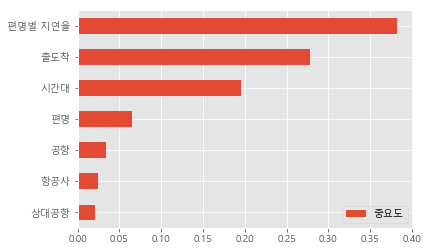

In [162]:
imp_data.sort_values(by='중요도').plot(kind='barh')
plt.show()

---

## Testing

### Scoring

In [163]:
score = round(model.score(X_test,y_test) *100,3)
score

69.604

### Forecasting

In [164]:
y_pred = model.predict(data_AFSNT_DLY[col])

In [165]:
pd.Series(y_pred).value_counts() / len(y_pred) * 100

0.0    100.0
dtype: float64

---

## Reference

### 항공기 정의 관련
- https://m.blog.naver.com/PostView.nhn?blogId=ijcho99&logNo=140069453089&proxyReferer=https%3A%2F%2Fwww.google.com%2F

### 항공기 지연 관련
- https://thebluesky.info/200
- https://m.blog.naver.com/PostView.nhn?blogId=kma_131&logNo=221309094506&proxyReferer=https%3A%2F%2Fwww.google.com%2F
- https://www.airport.co.kr/www/extra/stats/delayStats/layOut.do?cid=2015102917524762804&menuId=406